# Lab 4 - Regularized Least Squares

This lab is about employing Regularized Least Squares (RLS) to address regression problems.

In [327]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
import scipy.linalg
import os

##### Copy here below the code of the function to generate synthetic datasets for linear regression problems

In [328]:
def linearRegrFunction(n, D, low_D, high_D, W, sigma_noise):
   
    X = np.zeros((n,D))
    for i in range(0, D):
        X[:,i] = np.random.uniform(low_D[i], high_D[i], size=n)
    
    gauss_noise = np.random.normal(0, sigma_noise, size=(n,1))

    Y = np.dot(X, W) + gauss_noise
    
    return X, Y

In [329]:
def regularizedLSTrain(Xtr, Ytr, reg_par):
    Xtr = np.hstack((np.ones((Xtr.shape[0], 1)), Xtr))
    Z = reg_par * np.eye(Xtr.shape[1])
    Z[0, 0] = 0 
    w = np.dot(np.linalg.inv(np.dot(Xtr.T, Xtr) + np.dot(Z.T, Z)),
                             np.dot(Xtr.T, Ytr))
    return w 

##### Given two vectors — Ytrue (real outputs) and Ypred (predicted outputs) — you need a function to estimate the error when predicting Yp instead of Y. To this purpose you can use the MSE (Mean Square Error): 

In [330]:
def calcError(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

##### Write a function to evaluate a function estimated with RLS

In [331]:
def regularizedLSTest(w, Xtest):
    Xtest = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))
    Ypred = np.dot(Xtest,w)
    return Ypred

##### Generate a training set of n D-dimensional points 

In [332]:
n = 200
D = 1
w = np.array([1]).transpose()
w.shape = (D,1)
sigma_noise = 30
low_D = np.array([-100, -100])
high_D = np.array([100, 100])


Xtr, Ytr = linearRegrFunction(n, D, low_D, high_D, w, sigma_noise)

##### Pick a reasonable value for the regularization parameter and train the RLS on the training set
##### HINT: have a look at the computed matrix, to verify that IT IS symmetric and IF it is invertible (recalling that it is invertible when it has full rank...)

In [333]:
reg_par = 400
estw = regularizedLSTrain(Xtr, Ytr,reg_par )

##### Build a test set, with similar properties to the training set, and evaluate on it the trained model. Also, evaluate the error on the training set, then print both to have a look at their values

In [334]:
Xte, Yte = linearRegrFunction(n, D, low_D, high_D, w, sigma_noise)


test_err = calcError(regularizedLSTest(estw, Xte), Yte)
train_err = calcError(regularizedLSTest(estw, Xtr), Ytr) #regularizedLSTest(estw,Xtr)
                              
print("MSE on the test set "+str(test_err)) 
print("MSE on the training set "+str(train_err))

MSE on the test set 1113.5362389412167
MSE on the training set 1057.6872202113261


##### Build and plot the training and test error curves by repeiting the procedure above on different values of the regularization parameter

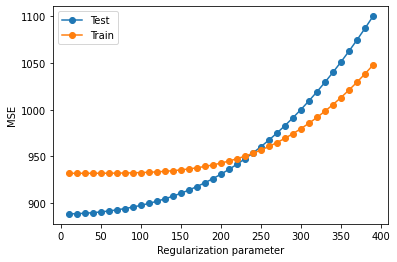

In [335]:

errstr = []
errste = []

for i in range(10,400,10):

    w = regularizedLSTrain(Xtr, Ytr,i )
    
    Ypred_tr = regularizedLSTest(w, Xtr)
    Ypred_te = regularizedLSTest(w, Xte)
    
    errs_tr= calcError(Ypred_tr, Ytr)
    errstr.append(errs_tr)
    
    errs_te= calcError(Ypred_te, Yte)
    errste.append(errs_te)
    
xi = [i for i in range(10,400,10)]

plt.plot(xi, errste,  '-o', label = 'Test')
plt.plot(xi, errstr, '-o', label = 'Train')
plt.legend()
plt.xlabel("Regularization parameter")
plt.ylabel("MSE")
plt.show()

##### Have a look at the following function, to perform K-Fold Cross Validation when training a RLS 

In [336]:
def KFoldCVRLS(Xtr, Ytr, KF, regpar_list):

    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    # Ensures that k_list is a numpy array
    regpar_list = np.array(regpar_list)
    num_regpar = regpar_list.size

    n_tot = Xtr.shape[0]
    n_val = int(np.ceil(n_tot/KF))

    Tm = np.zeros(num_regpar)
    Ts = np.zeros(num_regpar)
    Vm = np.zeros(num_regpar)
    Vs = np.zeros(num_regpar)

    # Random permutation of training data
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    
    
    for kdx, regpar in enumerate(regpar_list):
        first = 0
        for fold in range(KF):
           
            flags = np.zeros(Xtr.shape[0])
            flags[first:first+n_val]=1;
            
            X = Xtr[rand_idx[flags==0]]
            Y = Ytr[rand_idx[flags==0]]
            X_val = Xtr[rand_idx[flags==1]]
            Y_val = Ytr[rand_idx[flags==1]]

            # Compute the training error of the RLS regression for the given value of regpar
            currW = regularizedLSTrain(X, Y, regpar)
            YpredTR = regularizedLSTest(currW, X)
            trError = calcError(YpredTR, Y)
            Tm[kdx] = Tm[kdx] + trError
            Ts[kdx] = Ts[kdx] + trError ** 2

            # Compute the validation error of the RLS regression for the given value of regpar
            YpredVAL = regularizedLSTest(currW, X_val)
            valError = calcError(YpredVAL, Y_val)
            Vm[kdx] = Vm[kdx] + valError
            Vs[kdx] = Vs[kdx] + valError ** 2
            
            first = first+n_val                

    Tm = Tm / KF
    Ts = Ts / KF - Tm ** 2

    Vm = Vm / KF
    Vs = Vs / KF - Vm ** 2

    best_regpar_idx = np.argmin(Vm)
    bestregpar = regpar_list[best_regpar_idx]

    return bestregpar, Vm, Vs, Tm, Ts

In [347]:
bestregpar, Vm, Vs, Tm, Ts = KFoldCVRLS(Xtr, Ytr, 10, [i for i in range(5,500,5)])

In [348]:
len([i for i in range(5,500,5)])

99

##### Given the same array of possible values for the regularization parameter, select the best value with K-Fold Cross Validation, then train the model with the selected value and have a look to the test error

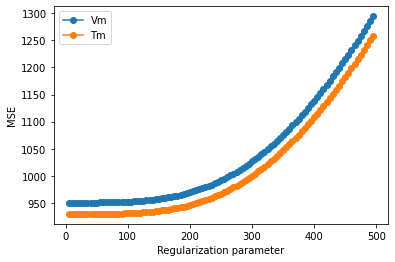

In [355]:
#KFoldCVRLS(Xtr, Ytr, KF, regpar_list)

reg_pars = [i for i in range(5,500,5)]
KF = 5
bestregpar, Vm, Vs, Tm, Ts = KFoldCVRLS(Xtr, Ytr, 5, reg_pars)

plt.plot(reg_pars, Vm, '-o',label = 'Vm')
plt.plot(reg_pars, Tm,'-o',label = 'Tm')
plt.xlabel("Regularization parameter")
plt.ylabel("MSE")
plt.legend()
plt.show()

##### Repeat the procedure above on a different dataset, sampled in a range non symmetric wrt the original, e.g. [2 5]
##### What changes? Reason on the further steps that you need to 

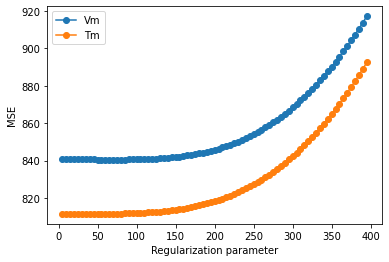

In [357]:
n = 300
D = 1
w = np.array([1]).transpose()
w.shape = (D,1)
sigma_noise = 28
low_D = np.array([-100, -100])
high_D = np.array([100, 100])


Xt, Yt = linearRegrFunction(n, D, low_D, high_D, w, sigma_noise)

#KFoldCVRLS(Xtr, Ytr, KF, regpar_list)

reg_pars = [i for i in range(5,400,5)]
KF = 5
bestregpar, Vm, Vs, Tm, Ts = KFoldCVRLS(Xt, Yt, 5, reg_pars)

plt.plot(reg_pars, Vm, '-o',label = 'Vm')
plt.plot(reg_pars, Tm,'-o',label = 'Tm')
plt.xlabel("Regularization parameter")
plt.ylabel("MSE")
plt.legend()
plt.show()